# Understanding and loading the dataset

In [1]:
# load required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
data=pd.read_csv('Corporate-messaging-DFE.csv')
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,category,category:confidence,category_gold,id,screenname,text
0,662822308,False,finalized,3,2/18/15 4:31,Information,1.0,NaN,4.365280e+17,Barclays,Barclays CEO stresses the importance of regula...
1,662822309,False,finalized,3,2/18/15 13:55,Information,1.0,NaN,3.860130e+17,Barclays,Barclays announces result of Rights Issue http...
2,662822310,False,finalized,3,2/18/15 8:43,Information,1.0,NaN,3.795800e+17,Barclays,Barclays publishes its prospectus for its �5.8...
3,662822311,False,finalized,3,2/18/15 9:13,Information,1.0,NaN,3.675300e+17,Barclays,Barclays Group Finance Director Chris Lucas is...
4,662822312,False,finalized,3,2/18/15 6:48,Information,1.0,NaN,3.603850e+17,Barclays,Barclays announces that Irene McDermott Brown ...


In [5]:
data.shape

(3118, 11)

In [6]:
data['category'].value_counts()

Information    2129
Action          724
Dialogue        226
Exclude          39
Name: category, dtype: int64

In [8]:
data['category:confidence'].value_counts()

1.0000    2430
0.6614      35
0.6643      33
0.6747      32
0.6775      29
          ... 
0.7202       1
0.8860       1
0.8570       1
0.6568       1
0.9041       1
Name: category:confidence, Length: 194, dtype: int64

In [10]:
data=data[(data['category:confidence']==1)&(data['category']!="Exclude")]

In [11]:

features=data['text']
target=data['category']

# Text Preprocessing

In [12]:
features[0]

'Barclays CEO stresses the importance of regulatory and cultural reform in financial services at Brussels conference  http://t.co/Ge9Lp7hpyG'

In [13]:
features[2]

'Barclays publishes its prospectus for its �5.8bn Rights Issue: http://t.co/YZk24iE8G6'

In [14]:
# import re library for regular expressions

import re
# import nltk library
import nltk

# import stopwords from nltk library
from nltk.corpus import stopwords

# download the stopwords and wordnet corpus
nltk.download('wordnet')
nltk.download('stopwords')


# extract the english stopwords and save it to a variable
stopword=stopwords.words('english')

# import word_tokenize from nltk library
from nltk.tokenize import word_tokenize

# import WordNetLemmatizer from nltk library
from nltk.stem import WordNetLemmatizer

# write a regular expression to identify urls in text
url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

# write a regular expression to identify non-ascii characters in text
non_ascii_regex = r'[^\x00-\x7F]+'

# write a function to tokenize text after performing preprocessing 
def tokenize(text):
    
    # use library re to replace urls by token - urlplaceholder
    text=re.sub(url_regex,'urlplaceholder',text)
    
    # use library re to replace non ascii characters by a space
    text=re.sub(non_ascii_regex," ",text)

    # use word_tokenize to tokenize the sentences
    tokens=word_tokenize(text)
    
    # instantiate an object of class WordNetLemmatizer
    lemmatizer=WordNetLemmatizer()

    # use a list comprehension to lemmatize the tokens and remove the the stopwords
    clean_tokens=[lemmatizer.lemmatize(word) for word in tokens if word not in stopword]

    # return the tokens
    return clean_tokens

[nltk_data] Downloading package wordnet to /home/lokesh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/lokesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# EDA

[nltk_data] Downloading package punkt to /home/lokesh/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-15-c246fadefc5e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['length']=data['text'].apply(lambda x: len(word_tokenize(x)))


<AxesSubplot:xlabel='category', ylabel='length'>

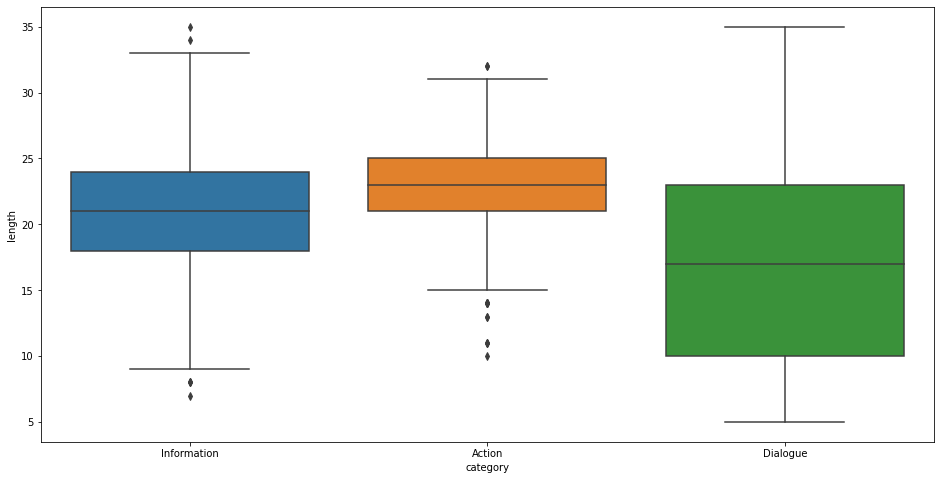

In [15]:
nltk.download('punkt')
# create a new column in the original dataset - 'length' to capture length of each text
data['length']=data['text'].apply(lambda x: len(word_tokenize(x)))

# use seaborn boxplot to visualize the pattern in length for each category
fig=plt.figure(figsize=(16,8))
sns.boxplot(x="category",y="length",data=data)

In [16]:
# create a new column in the original dataset - 'url_count' to capture total count of urls present in each text

data['url_count']=data['text'].apply(lambda x: len(re.findall(url_regex,x)))
# use pandas crosstab to see the distibution of different url counts in each category
pd.crosstab(data['category'],data['url_count'],normalize=True)

<ipython-input-16-66e78e1df1d6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['url_count']=data['text'].apply(lambda x: len(re.findall(url_regex,x)))


url_count,0,1,2
category,,,
Action,0.014565,0.166042,0.009155
Dialogue,0.032876,0.018727,0.000000
Information,0.205576,0.533916,0.019143


# Create Custom Transformers

In [17]:
# create a custom transformer LengthExtractor to extract length of each sentences
from sklearn.base import BaseEstimator, TransformerMixin
class LengthExtractor(BaseEstimator, TransformerMixin):
    def compute_length(self,text):
        sentence_list=word_tokenize(text)
        return len(sentence_list)
    
    def fit(self,x,y=None):
        return self
    def transform(self,X):
        X_length=pd.Series(X).apply(self.compute_length)
        return pd.DataFrame(X_length)

In [18]:
# create a custom transformer UrlCounter to count number of urls in each sentences
class UrlCounter(BaseEstimator,TransformerMixin):
    def count_url(self,text):
        urls=re.findall(url_regex,text)
        return len(urls)
    def fit(self,x,y=None):
        return self
    def transform(self,X):
        url_count=pd.Series(X).apply(self.count_url)
        return pd.DataFrame(url_count)


#  Model Building using FeatureUnion

In [19]:
# import RandomForestClassifier from sklearn
from sklearn.ensemble import RandomForestClassifier

# import Pipeline and FeatureUnion from sklearn
from sklearn.pipeline import Pipeline,FeatureUnion

# import CountVectorizer, TfidfTransformer from sklearn
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

In [20]:
# create an instance of Pipeline class
pipeline=Pipeline([
    
        # create a FeatureUnion pipeline
        ('features',FeatureUnion([

            # add a pipeline element to extract features using CountVectorizer and TfidfTransformer
            ('text_pipeline',Pipeline([
                ('vect',CountVectorizer(tokenizer=tokenize)),
                ('tfidf',TfidfTransformer())
            ])),

            # add the pipeline element - LengthExtractor to extract lenght of each sentence as feature
            ('text_len',LengthExtractor()),
            
            # add another pipeline element - UrlCounter to extract url counts in each sentence as feature
            ('url_count',UrlCounter())
        ])),

        # use the predictor estimator RandomForestClassifier to train the model
        ('clf',RandomForestClassifier())
])


In [21]:
# split the data into train and test sets

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(features,target,test_size=0.2,random_state=42)

In [22]:
# use pipeline.fit method to train the model

pipeline.fit(X_train,y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text_pipeline',
                                                 Pipeline(steps=[('vect',
                                                                  CountVectorizer(tokenizer=<function tokenize at 0x7efff94ccca0>)),
                                                                 ('tfidf',
                                                                  TfidfTransformer())])),
                                                ('text_len', LengthExtractor()),
                                                ('url_count', UrlCounter())])),
                ('clf', RandomForestClassifier())])

# Model Evaluation

In [23]:
# use the method pipeline.predict on X_test data to predict the labels
y_pred=pipeline.predict(X_test)



<AxesSubplot:>

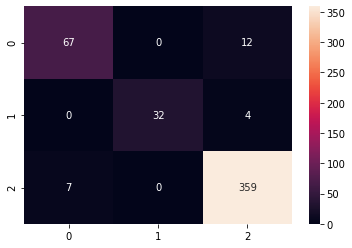

In [24]:
# create the confustion matrix, import confusion_matrix from sklearn

from sklearn.metrics import confusion_matrix
# count the number of labels
labels=np.unique(y_pred)

# use sns.heatmap on top of confusion_matrix to show the confusuin matrix
sns.heatmap(confusion_matrix(y_test,y_pred,labels=labels),annot=True,fmt='.0f')

In [25]:
# create the classification report, import classification_report from sklearn
from sklearn.metrics import classification_report

# apply the function classification_report on y_test, y_pred and print it
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      Action       0.91      0.85      0.88        79
    Dialogue       1.00      0.89      0.94        36
 Information       0.96      0.98      0.97       366

    accuracy                           0.95       481
   macro avg       0.95      0.91      0.93       481
weighted avg       0.95      0.95      0.95       481

